# Time dependent arrivals via thinning

This notebook provides an overview of how to use the `time_dependent.NSPPThinning` class.  

Thinning is an acceptance-rejection approach to sampling inter-arrival times (IAT) from a time dependent distribution where each time period follows its own exponential distribution.

There are two random variables employed in sampling: an exponential distribution (used to sample IAT) and a uniform distibution (used to accept/reject samples).

All IATs are sampled from an Exponential distribution with the highest arrival rate (most frequent). These arrivals are then rejected (thinned) proportional to the ratio of the current arrival rate to the maximum arrival rate.  The algorithm executes until a sample is accepted.  The IAT returned is the sum of all the IATs that were sampled.

## The thinning algorithm

A NSPP has arrival rate $\lambda(t)$ where $0 \leq t \leq T$

Here $i$ is the arrival number and $\mathcal{T_i}$ is its arrival time.

1. Let $\lambda^* = \max_{0 \leq t \leq T}\lambda(t)$ be the maximum of the arrival rate function and set $t = 0$ and $i=1$

2. Generate $e$ from the exponential distribution with rate $\lambda^*$ and let $t = t + e$ (this is the time of the next entity will arrive)

3. Generate $u$ from the $U(0,1)$ distribution.  If $u \leq \dfrac{\lambda(t)}{\lambda^*}$ then $\mathcal{T_i} =t$ and $i = i + 1$

4. Go to Step 2.

## `sim-tools` imports

In [1]:
from sim_tools.datasets import load_banks_et_al_nspp
from sim_tools.time_dependent import NSPPThinning

## general imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simpy
import itertools

## Example from Banks et al.

We will illustrate the use of `NSPPThinning` using an example from Banks et al. 

The table below breaks an arrival process down into 60 minutes intervals.


| t(min) | Mean time between arrivals (min) | Arrival Rate $\lambda(t)$ (arrivals/min) |
|:------:|:--------------------------------:|:--------------------------------------:|
|    0   |                15                |                  1/15                  |
|   60   |                12                |                  1/12                  |
|   120  |                 7                |                   1/7                  |
|   180  |                 5                |                   1/5                  |
|   240  |                 8                |                   1/8                  |
|   300  |                10                |                  1/10                  |
|   360  |                15                |                  1/15                  |
|   420  |                20                |                  1/20                  |
|   480  |                20                |                  1/20                  |


> **Interpretation**: In the table above the fastest arrival rate is 1/5 customers per minute or 5 minutes between customer arrivals.

In [38]:
banks_arrival_profile = load_banks_et_al_nspp()
banks_arrival_profile['mean_iat'] = 60.0 / banks_arrival_profile['arrival_rate']
banks_arrival_profile

,t,mean_iat,arrival_rate
0,0,900.0,0.066667
1,60,720.0,0.083333
2,120,420.0,0.142857
3,180,300.0,0.200000
4,240,480.0,0.125000
5,300,600.0,0.100000
6,360,900.0,0.066667
7,420,1200.0,0.050000
8,480,1200.0,0.050000


## Model

We define a simple experiment and Time Dependent model used only for counting the number of arrivals in an hour using thinning.

> `simpy` is used in a way to control for a fixed number of arrivals rather than a given run length.

In [4]:
class Experiment:
    def __init__(self, arrival_profile,
                 random_no_set=None):
        self.arrival_profile = arrival_profile

    def init_sampling(self, random_no_set=None):
        # producing 2 non-overlapping streams
        seed_sequence = np.random.SeedSequence(random_no_set)
        self.seeds = seed_sequence.spawn(2)
        
        self.nspp_rng = NSPPThinning(self.arrival_profile, self.seeds[0], 
                                     self.seeds[1])
        

In [17]:
class TimeDependentModel:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        # create array hold arrivals per hour of day.
        self.samples = [0] * experiment.arrival_profile.shape[0]
        self.n_arrivals = 0

    def arrivals_generator(self):
        for _ in itertools.count():
            # simulated arrival
            interarrival_time = self.experiment.nspp_rng.sample(self.env.now)
            yield self.env.timeout(interarrival_time)
    
            # add one to count for hour of the day
            hour_of_day = int(self.env.now // 60) % \
                self.experiment.arrival_profile.shape[0]
            self.samples[hour_of_day] += 1
            self.n_arrivals += 1

In [18]:
def single_run(experiment, run_length=540, random_no_set=0):
    """
    Run a single replication of the model.
    """
    # sim environment
    env = simpy.Environment()
    experiment.init_sampling(random_no_set)
    # create experiment and parameterise model
    model = TimeDependentModel(env, experiment)

    # set up simpy processes.
    env.process(model.arrivals_generator())
    env.run(run_length)

    return model.samples
    

In [28]:
def multiple_replications(experiment, run_length=540, n_reps=5):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    experiment: Experiment
        Parameters/arguments to configure the model
    
    run_length: float, optional (default=6540)
        results collection period in minutes.
        the number of minutes to run the model to collect results

    n_reps: int, optional (default=5)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''

    results = [single_run(experiment, run_length, rep) 
               for rep in range(n_reps)]
    
    #format and return results in a dataframe
    df_results = pd.DataFrame(results)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results


In [41]:
# create experiment and parameterise model
experiment = Experiment(banks_arrival_profile)
results = multiple_replications(experiment, run_length=540, n_reps=100_000)

results.mean(axis=0)

0    0.06622
1    0.06687
2    0.07257
3    0.07780
4    0.08280
5    0.08479
6    0.08158
7    0.07879
8    0.07699
dtype: float64

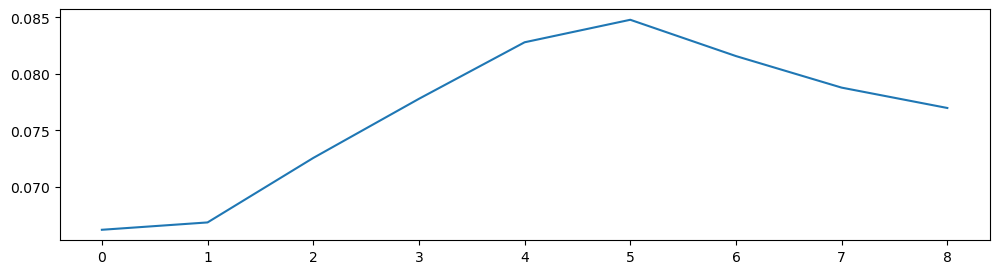

In [42]:
hour_means = results.mean(axis=0)

# visualise
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

# plot in this case returns a 2D line plot object
_ = ax.plot(hour_means)